In [8]:
import os
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from collections import defaultdict

# 随机种子
torch.manual_seed(42)
np.random.seed(42)

# 中文
plt.rcParams['font.sans-serif'] = ['KaiTi']  # 或者 'Microsoft YaHei', 'KaiTi', 'FangSong' 等
plt.rcParams['axes.unicode_minus'] = False

# 数据路径
json_dir = 'data/panasonic-floor-plan/train_annotations' # JSON文件夹路径
image_dir = 'data/panasonic-floor-plan/train_images/'  # 图片文件夹路径

统计所有的类和出现的次数

In [9]:

def get_all_categories(json_dir):
    """
    遍历目录下的所有JSON文件，收集所有出现的类别

    :param json_dir: 包含JSON文件的目录路径
    :return: 
        categories: 所有唯一类别的集合
        category_count: 每个类别出现的次数统计
    """
    categories = set()
    category_count = defaultdict(int)
    
    # 遍历目录下所有JSON文件
    for filename in os.listdir(json_dir):
        if filename.endswith('.json'):
            filepath = os.path.join(json_dir, filename)
            
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                # 提取当前文件中的所有类别
                if 'labels' in data:
                    for category in data['labels'].keys():
                        categories.add(category)
                        category_count[category] += 1
                        
            except Exception as e:
                print(f"处理文件 {filename} 时出错: {e}")
    
    return sorted(categories), category_count


all_categories, category_counts = get_all_categories(json_dir)

print("所有类别:", all_categories)
print("\n类别出现次数统计:")
for category, count in category_counts.items():
    print(f"{category}: {count}次")

所有类别: ['LDK', '廊下', '引戸', '折戸', '洋室', '浴室', '開戸']

类别出现次数统计:
LDK: 1320次
浴室: 1276次
廊下: 2147次
折戸: 1800次
開戸: 2059次
引戸: 1988次
洋室: 1607次


In [10]:
# 类别定义 (基于统计)
CLASSES = ['LDK', '浴室', '廊下', '折戸', '開戸', '引戸', '洋室']
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}

# # 颜色映射 (用于可视化)
# COLOR_MAP = {
#     'LDK': (255, 0, 0),      # 红色
#     '浴室': (0, 0, 255),      # 蓝色
#     '廊下': (0, 255, 0),      # 绿色
#     '折戸': (255, 165, 0),    # 橙色
#     '開戸': (128, 0, 128),    # 紫色
#     '引戸': (0, 255, 255),    # 青色
#     '洋室': (255, 192, 203)   # 粉色
# }

# 定义颜色映射
COLOR_MAP = {
    'LDK': 'red',
    '浴室': 'blue',
    '廊下': 'green',
    '折戸': 'orange',
    '開戸': 'purple',
    '引戸': 'cyan',
    '洋室': 'pink'
}



直方图

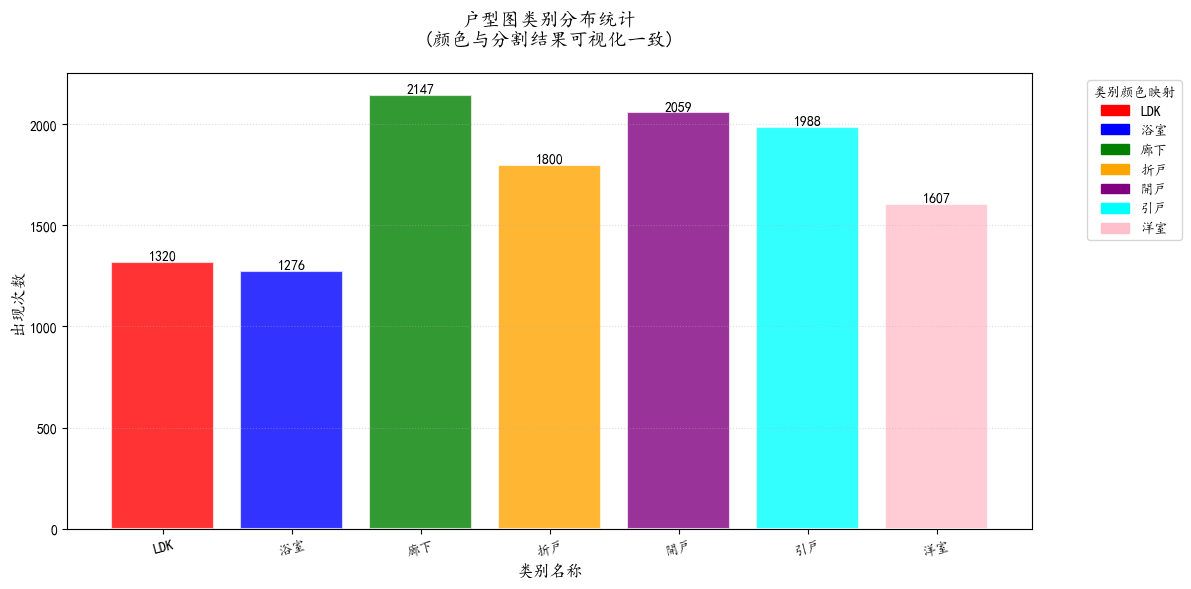

In [11]:
# 1. 准备数据（示例数据，实际替换为你的category_counts）
categories = list(category_counts.keys())
counts = list(category_counts.values())

# 2. 将颜色名称转换为RGB值（保持与可视化代码一致）
colors = [COLOR_MAP[cat] for cat in categories]

# 3. 创建画布
plt.figure(figsize=(12, 6), dpi=100)

# 4. 绘制柱状图（使用统一配色）
bars = plt.bar(categories, counts, color=colors, 
               edgecolor='white', linewidth=1.5, alpha=0.8)

# 5. 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom', 
             fontsize=10, color='black', weight='bold')

# 6. 图表美化
plt.title('户型图类别分布统计\n(颜色与分割结果可视化一致)', fontsize=14, pad=20)
plt.xlabel('类别名称', fontsize=12)
plt.ylabel('出现次数', fontsize=12)
plt.xticks(rotation=15)  # 适度旋转x轴标签
plt.grid(axis='y', linestyle=':', alpha=0.4)

# 7. 添加图例说明（可选）
legend_patches = [plt.Rectangle((0,0),1,1, color=COLOR_MAP[cat]) for cat in categories]
plt.legend(legend_patches, categories, 
           title='类别颜色映射',
           bbox_to_anchor=(1.05, 1), 
           loc='upper left')

# 8. 调整布局并显示
plt.tight_layout()
plt.show()


随机可视化一些图片和对应的标签

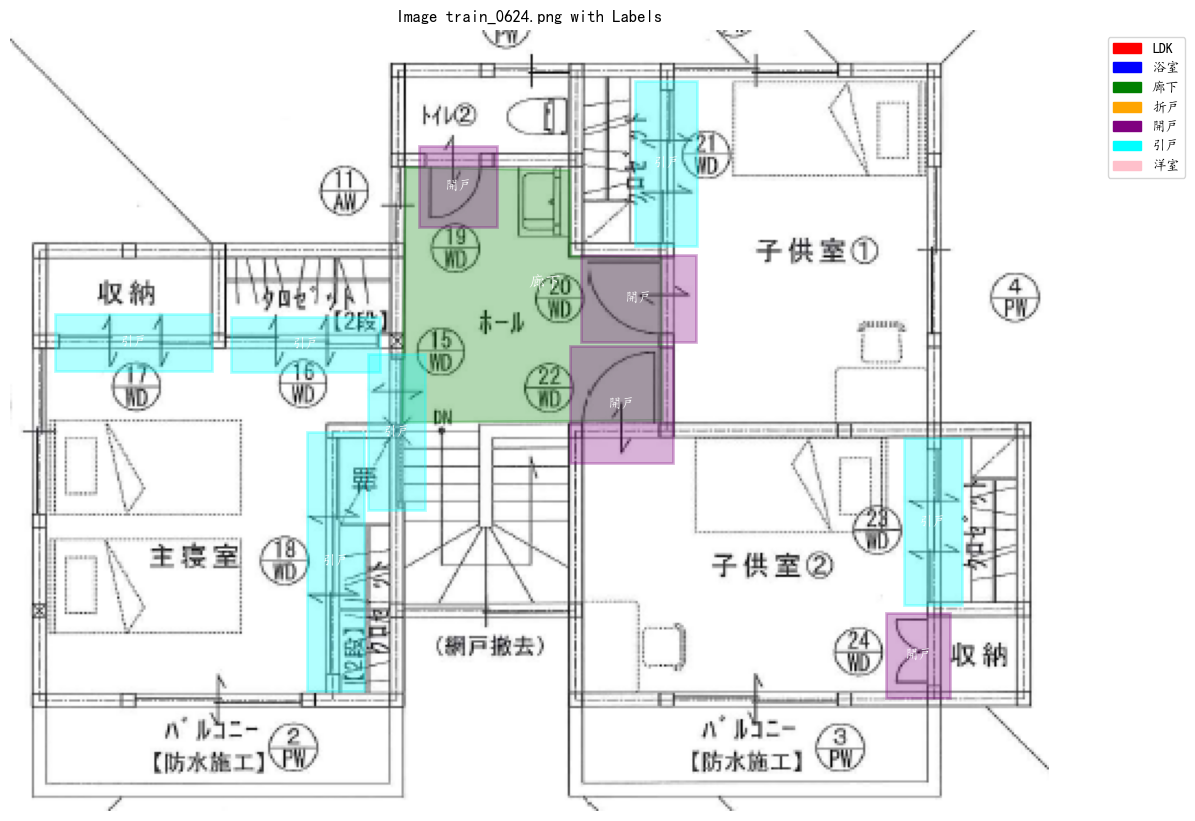

In [12]:
# 获取文件夹中的所有图片和JSON文件
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

# 确保图片和JSON文件数量匹配
assert len(image_files) == len(json_files), "图片和JSON文件数量不匹配"

# 随机选择一个文件对
random_index = random.randint(0, len(image_files) - 1)
image_file = image_files[random_index]
json_file = json_files[random_index]

# 加载图片
image_path = os.path.join(image_dir, image_file)
image = Image.open(image_path)
image = np.array(image)

# 读取JSON文件
json_path = os.path.join(json_dir, json_file)
with open(json_path, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

# 创建图形
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image)


# 绘制标签
for label_name, polygons in labels_data['labels'].items():
    color = COLOR_MAP.get(label_name, 'gray')
    
    # 处理多边形区域
    if label_name in ['LDK', '浴室', '廊下']:
        for polygon in polygons:
            polygon = np.array(polygon)
            patch = patches.Polygon(polygon, linewidth=2, edgecolor=color, facecolor=color, alpha=0.3)
            ax.add_patch(patch)
            # 添加标签文本
            center = polygon.mean(axis=0)
            ax.text(center[0], center[1], label_name, color='white', fontsize=12, ha='center', va='center')
    
    # 处理矩形区域
    elif label_name in ['折戸', '開戸', '引戸']:
        for rect in polygons:
            x1, y1, x2, y2 = rect
            width = x2 - x1
            height = y2 - y1
            rect_patch = patches.Rectangle((x1, y1), width, height, 
                                         linewidth=2, edgecolor=color, 
                                         facecolor=color, alpha=0.3)
            ax.add_patch(rect_patch)
            # 添加标签文本
            ax.text(x1 + width/2, y1 + height/2, label_name, 
                    color='white', fontsize=10, ha='center', va='center')

# 添加图例
legend_patches = []
for label, color in COLOR_MAP.items():
    legend_patches.append(patches.Patch(color=color, label=label))
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f'Image {image_file} with Labels')
plt.axis('off')
plt.tight_layout()
plt.show()

数据加载与预处理

In [13]:
class FloorPlanDataset(Dataset):
    def __init__(self, img_dir, json_dir, transform=None, target_size=(256, 256)):
        """
        收集所有待处理的PNG文件列表
        :param img_dir: 图片目录 路径
        :param json_dir: JSON标注目录 路径
        :param transform: 可选的预处理变换
        :param target_size: 目标尺寸
        """
        self.img_dir = img_dir    # 图片目录路径
        self.json_dir = json_dir  # JSON标注目录路径
        self.transform = transform  # 图像预处理变换
        self.filenames = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        self.target_size = target_size  # 新增目标尺寸参数
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        """
        读取图片和标注
        :param idx: 
        :return: 
        """
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)
        json_path = os.path.join(self.json_dir, img_name.replace('.png', '.json'))
        
        # 加载图像：用PIL库打开图片并转为RGB格式
        image = Image.open(img_path).convert('RGB')
        # 加载标注
        with open(json_path, 'r', encoding='utf-8') as f:
            annotations = json.load(f)
        
        # 创建空白mask：全零矩阵（大小与原图相同），存储类别标签
        mask = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
        
        # 填充mask
        for cls, polygons in annotations['labels'].items():
            if cls not in CLASS_TO_IDX:
                continue
                
            cls_id = CLASS_TO_IDX[cls]
            
            # 多边形区域
            if cls in ['LDK', '浴室', '廊下']:
                for polygon in polygons:  # polygons是[[[x1,y1], [x2,y2], ...]]
                    poly = np.array(polygon, dtype=np.int32)
                    cv2.fillPoly(mask, [poly], cls_id)
            
            # 矩形区域
            elif cls in ['折戸', '開戸', '引戸']:
                for rect in polygons:  # rect是[x1,y1,x2,y2]或[[x1,y1,x2,y2]]
                    # 处理可能的嵌套情况
                    if isinstance(rect[0], list):  # 如果是[[x1,y1,x2,y2]]
                        rect = rect[0]  # 取第一个元素
                    
                    try:
                        x1, y1, x2, y2 = map(int, rect)
                        cv2.rectangle(mask, (x1, y1), (x2, y2), cls_id, -1)
                    except (ValueError, TypeError) as e:
                        print(f"处理矩形时出错，文件: {img_name}, 类别: {cls}, 矩形数据: {rect}")
                        continue
                        
            # elif cls == '洋室':  # 特殊处理洋室（兼容多边形和矩形）
            #     for poly in polygons:
            #         if isinstance(poly[0], list):  # 多边形格式 [[x1,y1],[x2,y2],...]
            #             if len(poly) >= 3:  # 有效多边形
            #                 poly = np.array(poly, dtype=np.int32)
            #                 cv2.fillPoly(mask, [poly], cls_id)
            #         elif len(poly) == 4:  # 矩形格式 [x1,y1,x2,y2]
            #             try:
            #                 x1, y1, x2, y2 = map(int, map(round, poly))
            #                 cv2.rectangle(mask, (x1, y1), (x2, y2), cls_id, -1)
            #             except Exception as e:
            #                 print(f"洋室标注解析失败（文件{img_name}）：{poly} | 错误：{e}")
            #         else:
            #             print(f"无效洋室标注（文件{img_name}）：{poly}")
                    
        # 转换为Tensor + 统一尺寸
        # image = self.transform(image) if self.transform else transforms.ToTensor()(image)
        # mask = torch.from_numpy(mask).long()
        image = image.resize(self.target_size, Image.Resampling.BILINEAR)  # 图像用双线性插值
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)  # 标签用最近邻插值

        # 转换Tensor
        if self.transform:
            image = self.transform(image)  # transform应包含ToTensor()
        else:
            image = transforms.ToTensor()(image)
        
        mask = torch.from_numpy(mask).long()
        return image, mask


# 修改后的transform（去掉Resize，已在Dataset中处理）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

模型定义 (简单UNet)

In [14]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        
        self.maxpool = nn.MaxPool2d(2)
        
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        
        self.out = nn.Conv2d(64, n_classes, kernel_size=1)
    
    def forward(self, x):
        # 编码器
        conv1 = self.down1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.down3(x)
        x = self.maxpool(conv3)
        
        x = self.down4(x)
        
        # 解码器
        x = self.up1(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.conv1(x)
        
        x = self.up2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.conv3(x)
        
        return self.out(x)

 训练Pipeline

In [41]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')
    
    return model

完整Pipeline执行

In [45]:
def main():
    # 1. 准备数据
    dataset = FloorPlanDataset(img_dir='data/panasonic-floor-plan/train_images', 
                              json_dir='data/panasonic-floor-plan/train_annotations',
                              transform=transform)
    
    # 划分训练集和验证集
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # 创建DataLoader
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=4, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=4, shuffle=False)
    }
    
    # 2. 初始化模型
    model = UNet(NUM_CLASSES)
    
    # 3. 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 4. 训练模型
    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
    
    # 5. 保存模型
    torch.save(model.state_dict(), 'models/floorplan_segmentation.pth')

if __name__ == '__main__':
    main()

Epoch 0/9
----------
train Loss: 0.5396
val Loss: 0.4440
Epoch 1/9
----------
train Loss: 0.4363
val Loss: 0.4144
Epoch 2/9
----------
train Loss: 0.3949
val Loss: 0.3770
Epoch 3/9
----------
train Loss: 0.3522
val Loss: 0.3736
Epoch 4/9
----------
train Loss: 0.3253
val Loss: 0.3351
Epoch 5/9
----------
train Loss: 0.2969
val Loss: 0.4086
Epoch 6/9
----------
train Loss: 0.2719
val Loss: 0.4100
Epoch 7/9
----------
train Loss: 0.2468
val Loss: 0.3517
Epoch 8/9
----------
train Loss: 0.2246
val Loss: 0.2554
Epoch 9/9
----------
train Loss: 0.2076
val Loss: 0.2426


可视化与评估

In [15]:
# def visualize_results(model, dataset, num_samples=3):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model.eval()
#     
#     indices = np.random.choice(len(dataset), num_samples)
#     
#     for idx in indices:
#         image, mask = dataset[idx]
#         image = image.unsqueeze(0).to(device)
#         
#         with torch.no_grad():
#             output = model(image)
#             pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
#         
#         # 转换为彩色图像
#         def mask_to_color(mask_array):
#             h, w = mask_array.shape
#             color_mask = np.zeros((h, w, 3), dtype=np.uint8)
#             for cls, color in COLOR_MAP.items():
#                 if cls in CLASS_TO_IDX:
#                     color_mask[mask_array == CLASS_TO_IDX[cls]] = color
#             return color_mask
#         
#         gt_color = mask_to_color(mask.numpy())
#         pred_color = mask_to_color(pred)
#         
#         # 显示结果
#         plt.figure(figsize=(15, 5))
#         plt.subplot(1, 3, 1)
#         plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
#         plt.title('Original Image')
#         plt.axis('off')
#         
#         plt.subplot(1, 3, 2)
#         plt.imshow(gt_color)
#         plt.title('Ground Truth')
#         plt.axis('off')
#         
#         plt.subplot(1, 3, 3)
#         plt.imshow(pred_color)
#         plt.title('Prediction')
#         plt.axis('off')
#         
#         plt.show()
# 
# # 使用示例
# visualize_results(model, val_dataset)

NameError: name 'model' is not defined

语义分割结果的可视化

C:\Users\A123\AppData\Local\Temp\ipykernel_32672\904957044.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/floorplan_segmentati

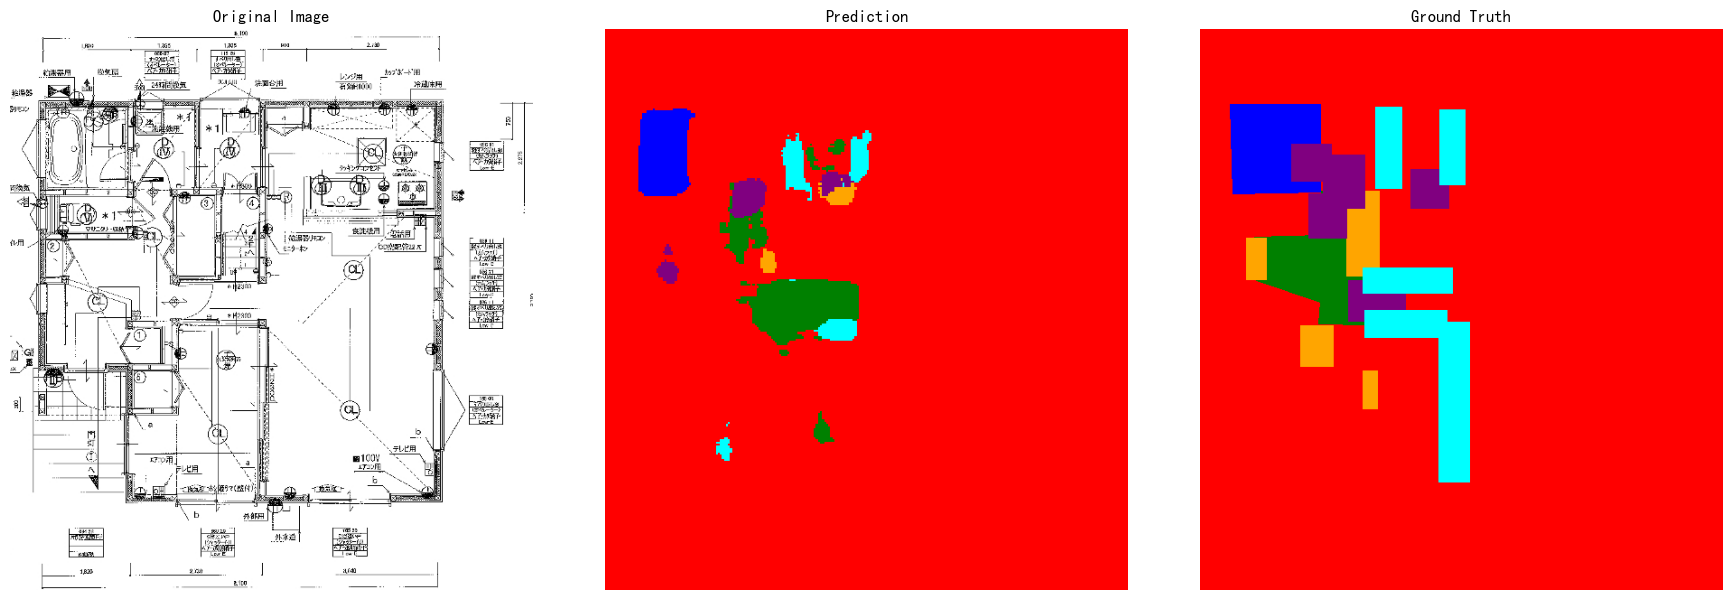

In [16]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import json
from torchvision import transforms
from matplotlib.colors import to_rgb

# 1. 定义类别和颜色映射（使用颜色名称）
CLASSES = ['LDK', '浴室', '廊下', '折戸', '開戸', '引戸', '洋室']
COLOR_MAP = {
    'LDK': 'red',
    '浴室': 'blue',
    '廊下': 'green',
    '折戸': 'orange',
    '開戸': 'purple',
    '引戸': 'cyan',
    '洋室': 'pink'
}

# 将颜色名称转换为RGB值（Matplotlib兼容）
COLOR_RGB = {cls: (np.array(to_rgb(color)) * 255).astype(np.uint8) 
             for cls, color in COLOR_MAP.items()}

# 2. 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(len(CLASSES)).to(device)  # 替换为你的模型定义
model.load_state_dict(torch.load('models/floorplan_segmentation.pth', map_location=device))
model.eval()

# 3. 预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. 可视化函数
def visualize_prediction(image_path, json_path=None):
    # 加载图像
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # 预测
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    # 调整mask大小
    pred_mask = cv2.resize(pred_mask, original_size, interpolation=cv2.INTER_NEAREST)
    
    # 生成彩色mask（使用COLOR_RGB）
    def mask_to_color(mask_array):
        h, w = mask_array.shape
        color_mask = np.zeros((h, w, 3), dtype=np.uint8)
        for idx, cls in enumerate(CLASSES):
            color_mask[mask_array == idx] = COLOR_RGB[cls]
        return color_mask
    
    pred_color = mask_to_color(pred_mask)
    
    # 可视化
    plt.figure(figsize=(18, 6))
    
    # 原始图像
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    # 预测结果
    plt.subplot(1, 3, 2)
    plt.imshow(pred_color)
    plt.title("Prediction")
    plt.axis('off')
    
    # 如果有标注，显示Ground Truth
    if json_path:
        with open(json_path, 'r', encoding='utf-8') as f:
            annotations = json.load(f)
        
        gt_mask = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)
        for cls, polygons in annotations['labels'].items():
            if cls not in CLASSES:
                continue
            cls_id = CLASSES.index(cls)
            
            if cls in ['LDK', '浴室', '廊下']:
                for polygon in polygons:
                    poly = np.array(polygon, dtype=np.int32)
                    cv2.fillPoly(gt_mask, [poly], cls_id)
            else:
                for rect in polygons:
                    if isinstance(rect[0], list):
                        rect = rect[0]
                    x1, y1, x2, y2 = map(int, rect)
                    cv2.rectangle(gt_mask, (x1, y1), (x2, y2), cls_id, -1)
        
        gt_color = mask_to_color(gt_mask)
        plt.subplot(1, 3, 3)
        plt.imshow(gt_color)
        plt.title("Ground Truth")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 5. 使用示例
image_path = "data/panasonic-floor-plan/train_images/train_0000.png"  # 替换为测试图片路径
json_path = "data/panasonic-floor-plan/train_annotations/train_0000.json"  # 可选标注文件
visualize_prediction(image_path, json_path)

C:\Users\A123\AppData\Local\Temp\ipykernel_26256\3683911183.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/floorplan_segmentat

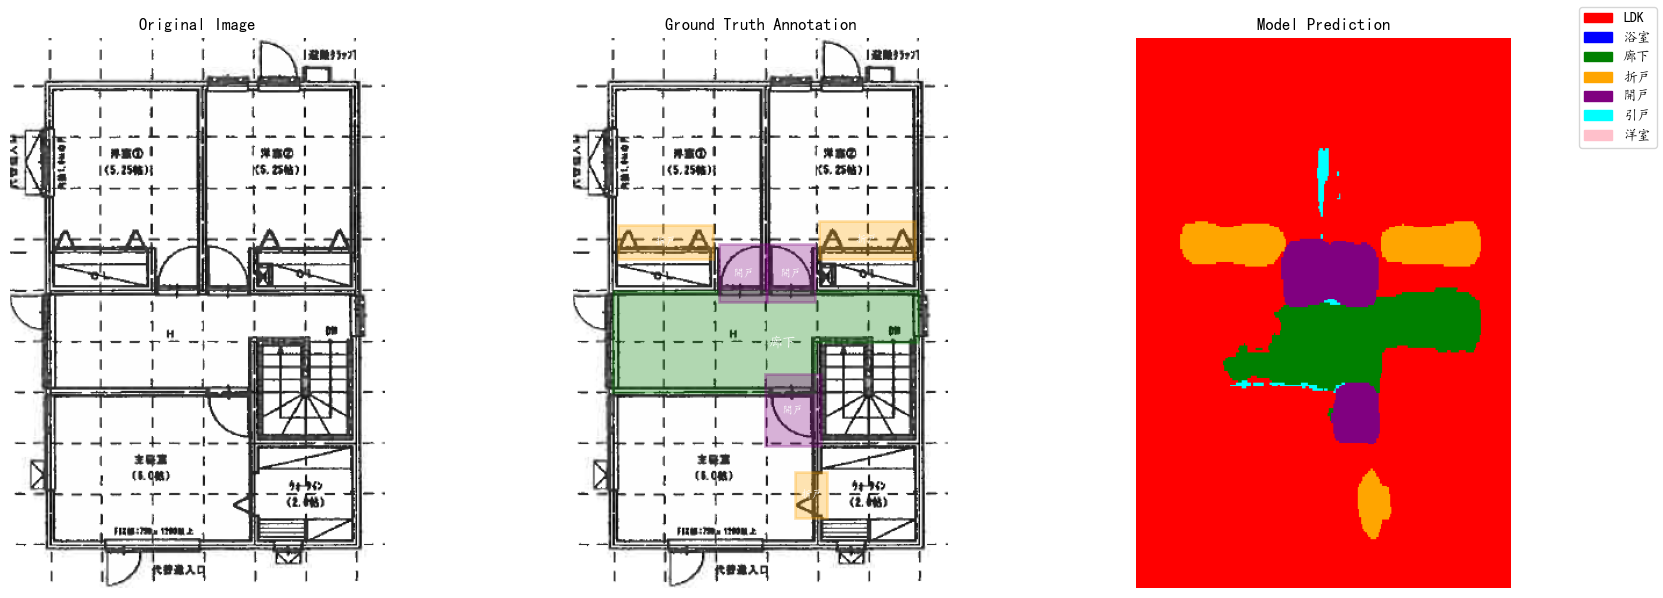

In [63]:
import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from torchvision import transforms
import cv2
from matplotlib.colors import to_rgb

# 定义类别和颜色映射
CLASSES = ['LDK', '浴室', '廊下', '折戸', '開戸', '引戸', '洋室']
COLOR_MAP = {
    'LDK': 'red',
    '浴室': 'blue',
    '廊下': 'green',
    '折戸': 'orange',
    '開戸': 'purple',
    '引戸': 'cyan',
    '洋室': 'pink'
}

# 将颜色名称转换为RGB值
COLOR_RGB = {cls: (np.array(to_rgb(color)) * 255).astype(np.uint8) 
             for cls, color in COLOR_MAP.items()}

# 加载训练好的模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(len(CLASSES)).to(device)  # 请替换为你的模型定义
model.load_state_dict(torch.load('models/floorplan_segmentation.pth', map_location=device))
model.eval()

# 定义预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# 随机选择一张图像
random_index = random.randint(0, len(image_files) - 1)
image_file = image_files[random_index]
json_file = json_files[random_index]

# 加载图像和标注
image_path = os.path.join(image_dir, image_file)
json_path = os.path.join(json_dir, json_file)

image = Image.open(image_path)
original_image = np.array(image)
with open(json_path, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

# 创建图形
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# 子图1: 原始图像
ax1.imshow(original_image)
ax1.set_title("Original Image")
ax1.axis('off')

# 子图2: 带标注的可视化
ax2.imshow(original_image)
for label_name, polygons in labels_data['labels'].items():
    color = COLOR_MAP.get(label_name, 'gray')
    
    if label_name in ['LDK', '浴室', '廊下']:
        for polygon in polygons:
            polygon = np.array(polygon)
            patch = patches.Polygon(polygon, linewidth=2, edgecolor=color, 
                                  facecolor=color, alpha=0.3)
            ax2.add_patch(patch)
            center = polygon.mean(axis=0)
            ax2.text(center[0], center[1], label_name, color='white', 
                     fontsize=10, ha='center', va='center')
    
    elif label_name in ['折戸', '開戸', '引戸']:
        for rect in polygons:
            if isinstance(rect[0], list):
                rect = rect[0]
            x1, y1, x2, y2 = rect
            width = x2 - x1
            height = y2 - y1
            rect_patch = patches.Rectangle((x1, y1), width, height,
                                         linewidth=2, edgecolor=color,
                                         facecolor=color, alpha=0.3)
            ax2.add_patch(rect_patch)
            ax2.text(x1 + width/2, y1 + height/2, label_name,
                    color='white', fontsize=8, ha='center', va='center')

ax2.set_title("Ground Truth Annotation")
ax2.axis('off')

# 子图3: 模型预测结果
input_tensor = transform(image).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(input_tensor)
    pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# 调整mask大小并转换为彩色
pred_mask = cv2.resize(pred_mask, original_image.shape[:2][::-1], 
                      interpolation=cv2.INTER_NEAREST)
pred_color = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
for idx, cls in enumerate(CLASSES):
    pred_color[pred_mask == idx] = COLOR_RGB[cls]

ax3.imshow(pred_color)
ax3.set_title("Model Prediction")
ax3.axis('off')

# 添加图例
legend_patches = [patches.Patch(color=color, label=cls) 
                 for cls, color in COLOR_MAP.items()]
fig.legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.show()